In [1]:
# Importações

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    QuantileTransformer,
    PolynomialFeatures,
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


import re


from src.config import CLEANED_PATH, FINAL_MODEL
from src.graphics import compareMetrics, plotCoeffs, plotResiduals, plotResidualsFromEstimator
from src.models import trainAndValidate, gridSearch
from src.utils import organizeResults, getCoeffsDataframe

In [2]:
# Obtendo os dados limpos
df = pd.read_parquet(CLEANED_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_households,population_per_households,bedrooms_per_rooms,median_income_cat,housing_median_age_cat
0,-122.25,37.849998,52,1274,235,558,219,5.6431,341300,NEAR BAY,5.817352,2.547945,0.184458,4,4
1,-122.25,37.849998,52,1627,280,565,259,3.8462,342200,NEAR BAY,6.281853,2.181467,0.172096,3,4
2,-122.25,37.849998,52,919,213,413,193,4.0368,269700,NEAR BAY,4.761658,2.139896,0.231774,3,4
3,-122.25,37.840000,52,2535,489,1094,514,3.6591,299200,NEAR BAY,4.931907,2.128405,0.192899,3,4
4,-122.25,37.840000,52,3104,687,1157,647,3.1200,241400,NEAR BAY,4.797527,1.788253,0.221327,3,4


In [3]:
# Resumo da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   longitude                  17340 non-null  float32
 1   latitude                   17340 non-null  float32
 2   housing_median_age         17340 non-null  int8   
 3   total_rooms                17340 non-null  int16  
 4   total_bedrooms             17340 non-null  int16  
 5   population                 17340 non-null  int16  
 6   households                 17340 non-null  int16  
 7   median_income              17340 non-null  float32
 8   median_house_value         17340 non-null  int32  
 9   ocean_proximity            17340 non-null  object 
 10  rooms_per_households       17340 non-null  float64
 11  population_per_households  17340 non-null  float64
 12  bedrooms_per_rooms         17340 non-null  float64
 13  median_income_cat          17340 non-null  int

In [4]:
# Definição das colunas de cada transformação

target_column = ["median_house_value"]

ordinal_columns = ["median_income_cat", "housing_median_age_cat"]

one_hot_columns = ["ocean_proximity"]

robust_scaler_columns = df.columns.difference(
    target_column + one_hot_columns + ordinal_columns
    )

In [5]:
# Definição dos preprocessamentos

pipeline_robust = Pipeline(
    [
        ("poly", PolynomialFeatures(
            degree=1,
            include_bias=False
            )
        ),
        ("robust", RobustScaler())
    ]
)

preprocessing = ColumnTransformer(
    [
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), ordinal_columns),
        ("one_hot", OneHotEncoder(drop="first"), one_hot_columns),
        ("robust_poly", pipeline_robust, robust_scaler_columns)
    ],
)

In [6]:
# Separação das features e do target
X = df.drop(target_column, axis=1)
y = df[target_column[0]]

In [7]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Definindo a grade de parametros

param_grid = {
    "regressor__preprocessing__robust_poly__poly__degree": [1, 2, 3],
    "regressor__regressor__alpha": [1e-2, 5e-2, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50],
}

In [9]:
# Definição do grid search

grid_search = gridSearch(
    regressor=Ridge(),
    preprocessing=preprocessing,
    target_transform=QuantileTransformer(
        n_quantiles=1_000, 
        output_distribution="normal"
        ),
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_poly',
                                                                                                              Pipeline(steps=[...
                                                                            ('regressor',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessing__robust_poly__poly__degree': [1,
                                                                                 2,
                                                                                 3],
                         'regressor__regressor__alpha': [0.01, 0.05, 0.1, 0.25,
                                                         0.5, 1, 2, 5, 10, 20,
                                                         50]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=1)

In [10]:
# Ajuste dos pesos
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_poly',
                                                                                                              Pipeline(steps=[...
                                                                            ('regressor',
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessing__robust_poly__poly__degree': [1,
                                                                                 2,
                                                                                 3],
                         'regressor__regressor__alpha': [0.01, 0.05, 0.1, 0.25,
                                                         0.5, 1, 2, 5, 10, 20,
                                                         50]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=1)

In [11]:
# Melhores parametros
grid_search.best_params_

{'regressor__preprocessing__robust_poly__poly__degree': 3,
 'regressor__regressor__alpha': 0.01}

In [12]:
# Estimador com melhores parametros
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat',
                                                                                        'housing_median_age_cat']),
                                                                                      ('one_hot',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('robust_poly',
                                                                                       Pipeline(steps=[('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False)),
                                                                                                       ('robust',
                                                                                                        RobustScaler())]),
                                                                                       Index(['bedrooms_per_rooms', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_households',
       'rooms_per_households', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                     ('regressor',
                                                      Ridge(alpha=0.01))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [13]:
# Coeficientes das features

df_coeffs = getCoeffsDataframe(
    grid_search.best_estimator_.regressor_["regressor"].coef_,
    grid_search.best_estimator_.regressor_["preprocessing"].get_feature_names_out(),
)
df_coeffs

,coeficientes
robust_poly__housing_median_age longitude median_income,-10.112958
robust_poly__median_income,-9.697612
robust_poly__latitude population_per_households,-9.253074
robust_poly__median_income population_per_households total_bedrooms,-6.980918
robust_poly__bedrooms_per_rooms longitude median_income,-6.896695
...,...
robust_poly__bedrooms_per_rooms housing_median_age total_rooms,6.441612
robust_poly__housing_median_age total_bedrooms,6.441612
robust_poly__bedrooms_per_rooms longitude total_bedrooms,6.607395
robust_poly__bedrooms_per_rooms^2 latitude,7.397763


In [14]:
# Verificando se algum coeficiente foi zerado
df_coeffs[df_coeffs["coeficientes"] == 0]

,coeficientes


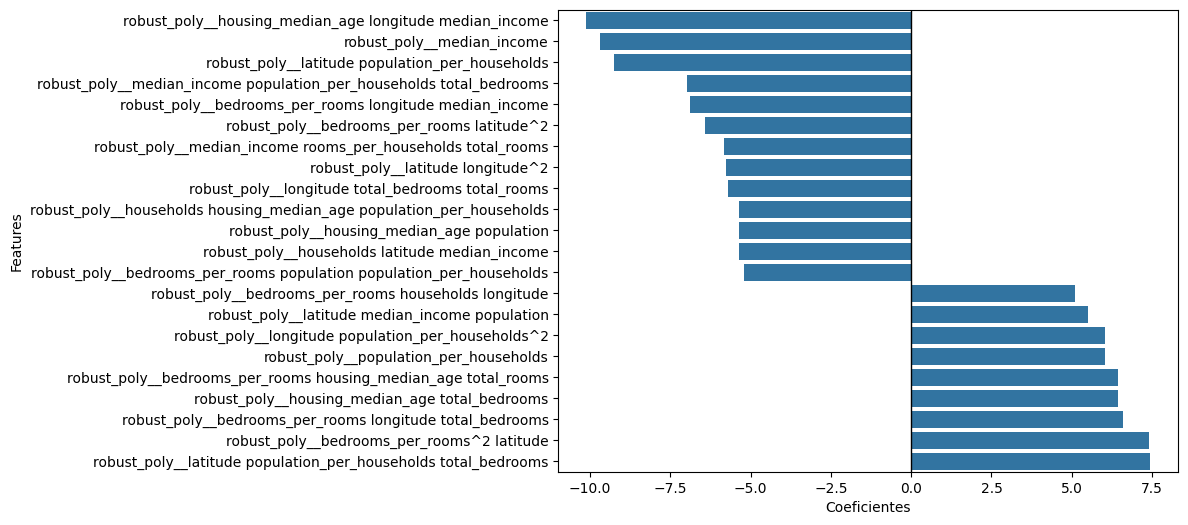

In [15]:
# Gerando gráfico desses coeficientes
plotCoeffs(
    df_coeffs[~df_coeffs["coeficientes"].between(
        -5, 5
        )]
    )

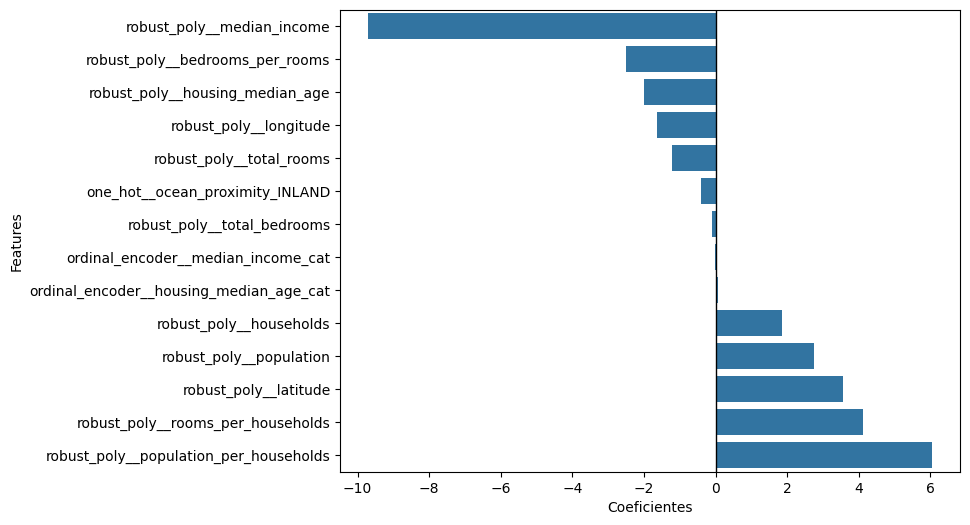

In [16]:
# Gerando gráfico desses coeficientes dos parametros lineares
non_linear_pattern = re.compile(r"\^[2-9]")

linear_parameters = df_coeffs.index[
    ~(df_coeffs.index.str.contains(" ")) & 
    ~(df_coeffs.index.str.contains(non_linear_pattern))
    ]

plotCoeffs(
    df_coeffs.loc[linear_parameters]
    )

In [17]:
# Definição dos regressores, com ou sem preprocessamentos nas coluna e/ou transformação no target

regressors = {
    "DummyRegressor": {
        "preprocessing": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transform": None,
    },
    "LinearRegression": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": None,
    },
    "LinearRegression_target": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": QuantileTransformer(
            n_quantiles=1_000,
            output_distribution="normal"
        ),
    },
    "Ridge_grid_search": {
        "preprocessing": grid_search.best_estimator_.regressor_["preprocessing"],
        "regressor": grid_search.best_estimator_.regressor_["regressor"],
        "target_transform": grid_search.best_estimator_.transformer_,
    },
}

# Obtendo os resultados de cada regressor

results = {
    name: trainAndValidate(X, y, **regressor) for name, regressor in regressors.items()
}

df_results = organizeResults(results)
df_results

,model,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time
0,DummyRegressor,-74496.622,-91828.212064,-0.000031,0.010102
1,DummyRegressor,-74033.8009,-90953.345064,-0.000072,0.007257
2,DummyRegressor,-73436.810725,-91261.635258,-0.000214,0.007283
3,DummyRegressor,-75005.696104,-92007.342962,-0.000095,0.009029
4,DummyRegressor,-74476.318859,-91827.966753,-0.000058,0.004429
5,LinearRegression,-40461.156491,-53585.381591,0.659471,0.055222
6,LinearRegression,-40497.930626,-53229.728607,0.657467,0.060232
7,LinearRegression,-40657.91515,-54061.914203,0.649006,0.051988
8,LinearRegression,-39544.196294,-53556.524508,0.661139,0.0551
9,LinearRegression,-39999.623133,-53140.949033,0.665085,0.045028


In [18]:
# Agrupando a mediana das métricas de cada modelo
df_results.groupby("model").median()

,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time
model,,,,
DummyRegressor,-74476.318859,-91827.966753,-0.000072,0.007283
LinearRegression,-40461.156491,-53556.524508,0.659471,0.0551
LinearRegression_target,-38396.27296,-52551.13055,0.670177,0.065781
Ridge_grid_search,-34968.981872,-49030.654326,0.711861,0.858494


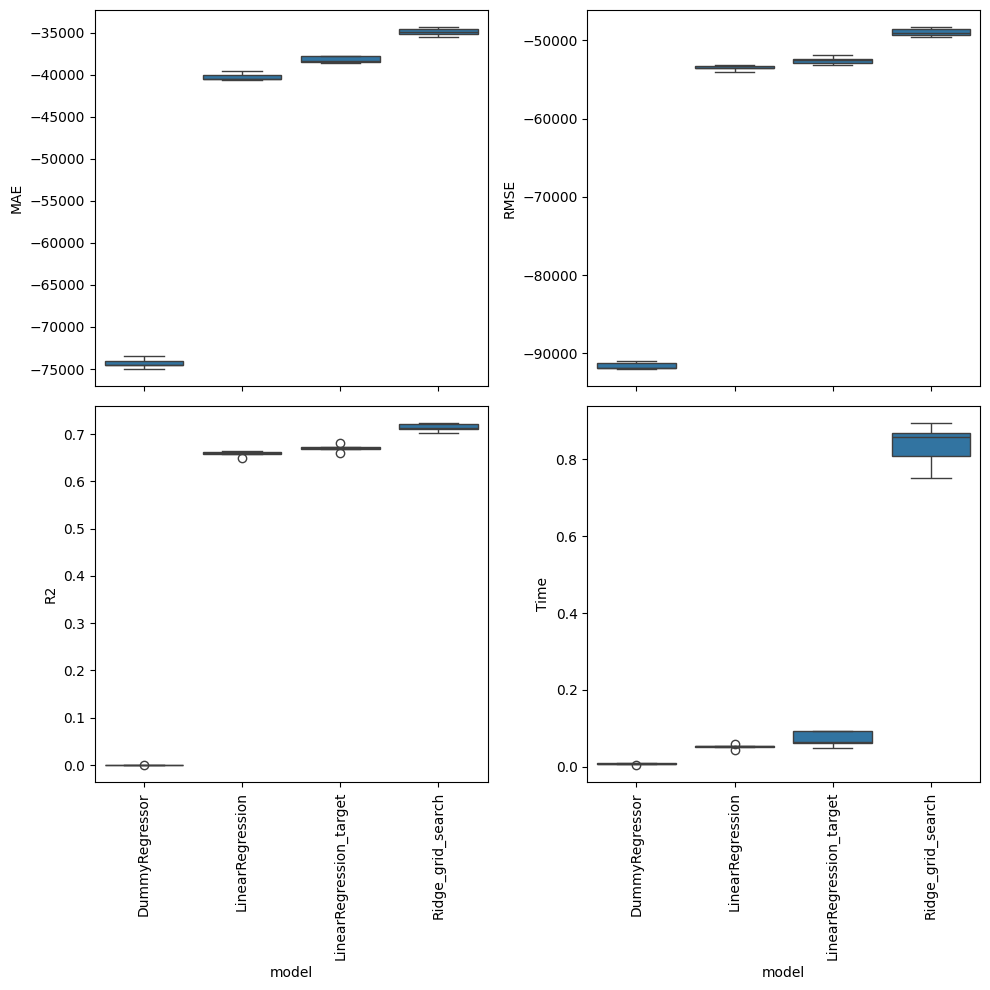

In [19]:
# Comparação das métricas de cada modelo
compareMetrics(df_results, ["MAE", "RMSE", "R2", "Time"])

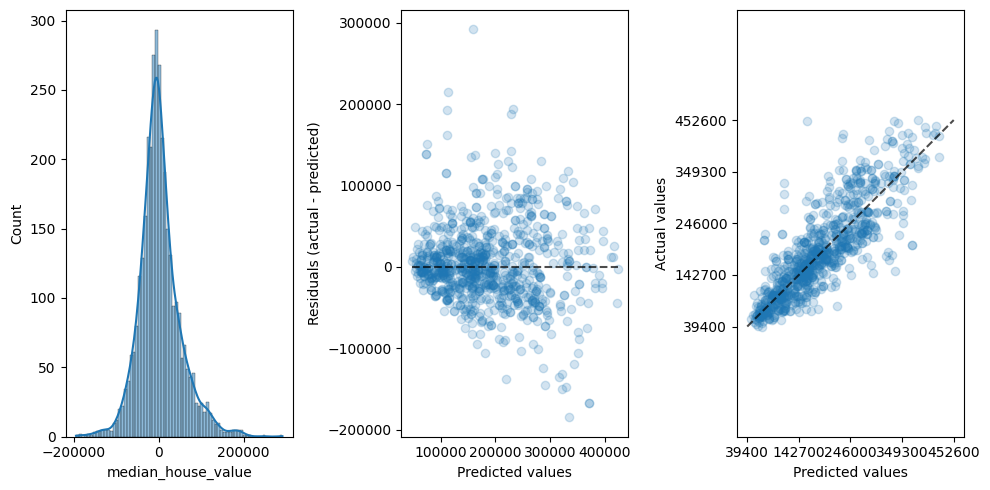

In [20]:
# Gráficos de residuos

y_pred = grid_search.best_estimator_.predict(X_test)

plotResiduals(y_test, y_pred)

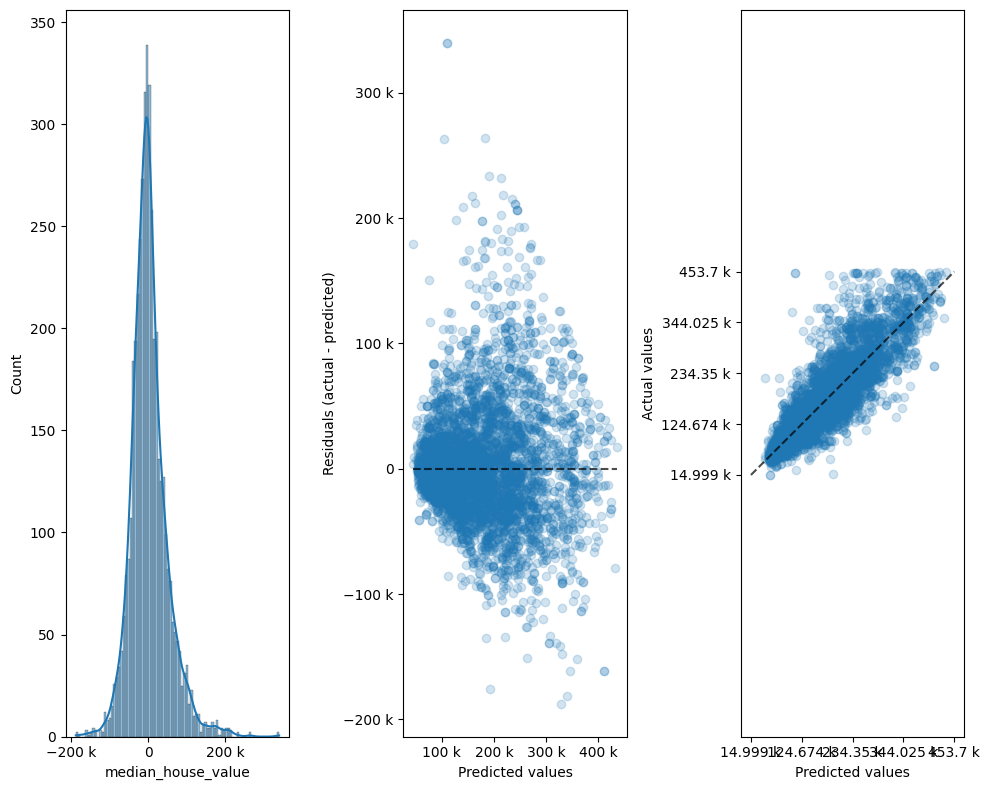

In [21]:
plotResidualsFromEstimator(grid_search.best_estimator_, X, y, eng_formatter=True)

In [22]:
# Salvando o modelo
joblib.dump(
    grid_search.best_estimator_, 
    FINAL_MODEL
    )

['/home/lucas/Documentos/python/california_median_price_value_regressor/models/ridge_polyfeat_target_quantile.joblib']